<a href="https://colab.research.google.com/github/ehsung/PUBH6886/blob/main/PUBH6886_RLabs11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUBH 6886: R Lab 011

## Edward Sung

## 12/03/24

# Code from Lecture 11

>[Boosted Regression Tree](#updateTitle=true&folderId=1r-g8wJfeKaGd9a8yLWY3NoKaegmzbrzB&scrollTo=SaT1cs4Rr1dS)

>[Boosted Classification Tree](#updateTitle=true&folderId=1r-g8wJfeKaGd9a8yLWY3NoKaegmzbrzB&scrollTo=QI9h3_F62r_0)



In [ ]:
# Install Libraries
install.packages("caret")
install.packages("gbm")
install.packages("readr")
install.packages("gridExtra")

In [56]:
# Libraries
library(readr)
library(dplyr)
library(caret)
library(gbm)
library(gridExtra)

# Boosted Regression Tree

In [ ]:
# load the prostate data
prostate_data <- read_csv("/content/prostate_data.csv")

# training data set
prostate_data_train <- prostate_data[prostate_data$train, ]

# testing data set
prostate_data_test <- prostate_data[!prostate_data$train, ]

In [58]:
# fit boosted regression tree
set.seed(1234)

gbm_reg <- gbm(lpsa ~ lcavol + lweight + age + lbph + svi + lcp + gleason + pgg45,
  distribution = "gaussian", n.trees = 500, interaction.depth = 1,
  shrinkage = 0.01, n.minobsinnode = 10, bag.fraction = 0.50, cv.folds = 10,
  data = prostate_data_train)

gbm_reg

gbm(formula = lpsa ~ lcavol + lweight + age + lbph + svi + lcp + 
    gleason + pgg45, distribution = "gaussian", data = prostate_data_train, 
    n.trees = 500, interaction.depth = 1, n.minobsinnode = 10, 
    shrinkage = 0.01, bag.fraction = 0.5, cv.folds = 10)
A gradient boosted model with gaussian loss function.
500 iterations were performed.
The best cross-validation iteration was 392.
There were 8 predictors of which 8 had non-zero influence.

In [59]:
sqrt(gbm_reg$cv.error[392])

[1] 0.8709008

In [60]:
gbm_reg_pred <- predict(gbm_reg, newdata = prostate_data_test, n.trees = 392)
gbm_reg_pred

[1] 1.538646 1.313959 1.045963 1.907923 2.841298 1.871096 1.800320 2.316616
 [9] 1.996816 1.076761 2.782010 2.677451 3.036658 3.115824 2.197426 2.035323
[17] 2.122879 3.612635 2.659660 1.733309 3.635172 3.711439 2.362968 2.977256
[25] 2.943159 2.758978 3.638161 3.756456 2.768927 3.650664

In [61]:
sqrt(mean((prostate_data_test$lpsa - gbm_reg_pred)^2))

[1] 0.7895841

,var,rel.inf
,<chr>,<dbl>
lcavol,lcavol,42.115147
lweight,lweight,28.721331
pgg45,pgg45,9.217955
gleason,gleason,5.434618
lbph,lbph,4.852370
lcp,lcp,3.417776
svi,svi,3.376050
age,age,2.864752


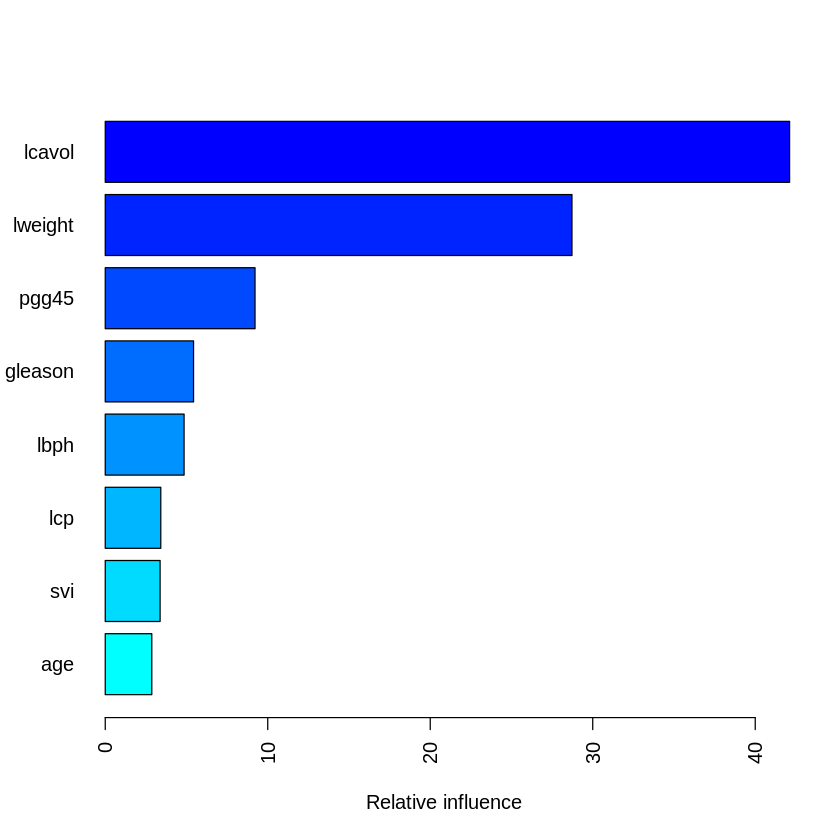

In [62]:
# relative influence approach
summary(gbm_reg, method = relative.influence,
normalize = TRUE, las = 2)

var,rel.inf
<chr>,<dbl>
lcavol,47.5375643
lweight,39.3052891
pgg45,7.3721535
lbph,2.2408391
gleason,2.1598829
svi,0.8619805
age,0.3544584
lcp,0.1678322


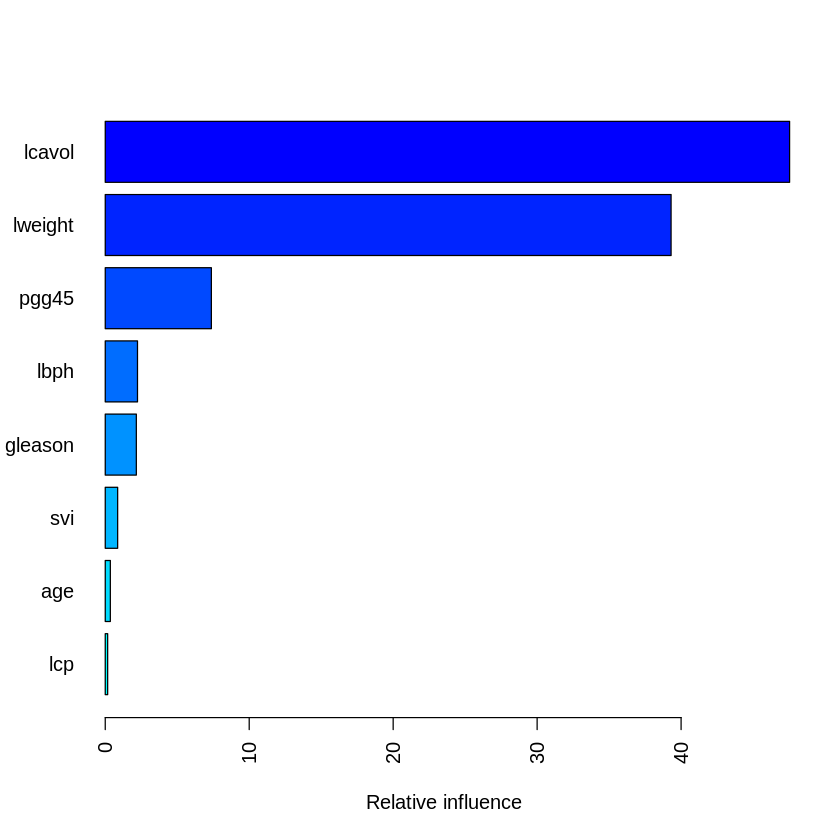

In [63]:
# permutation approach
summary(gbm_reg, method = permutation.test.gbm,
normalize = TRUE, las = 2)

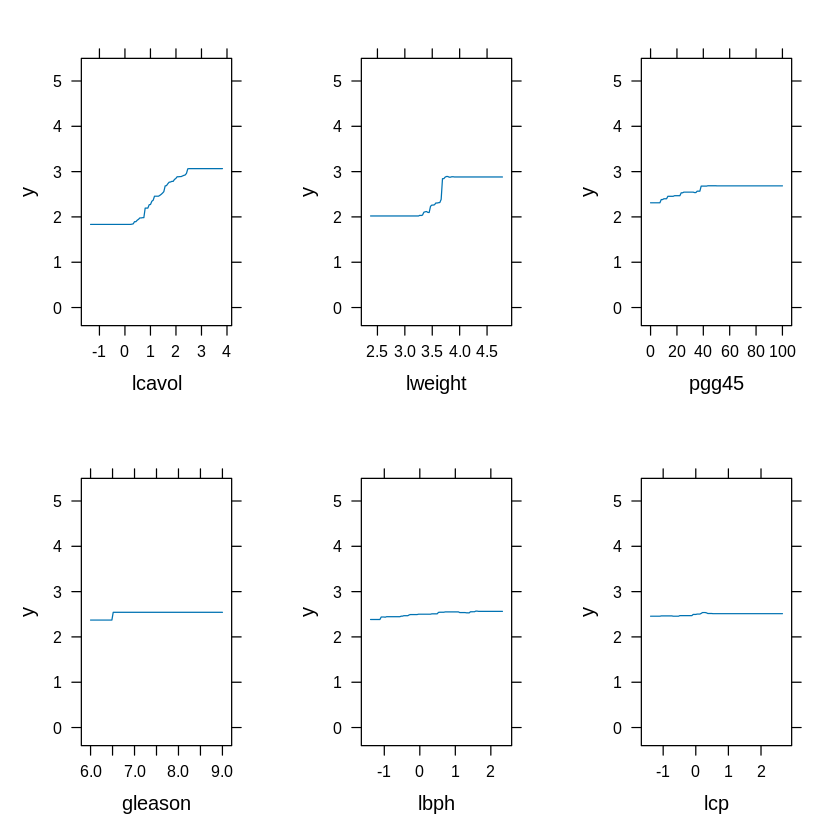

In [64]:
p1 <- plot(gbm_reg, i = "lcavol", ylim = c(-0.40, 5.5))
p2 <- plot(gbm_reg, i = "lweight", ylim = c(-0.40, 5.5))
p3 <- plot(gbm_reg, i = "pgg45", ylim = c(-0.40, 5.5))
p4 <- plot(gbm_reg, i = "gleason", ylim = c(-0.40, 5.5))
p5 <- plot(gbm_reg, i = "lbph", ylim = c(-0.40, 5.5))
p6 <- plot(gbm_reg, i = "lcp", ylim = c(-0.40, 5.5))

grid.arrange(p1, p2, p3, p4, p5, p6, ncol = 3, nrow = 2)

In [ ]:
# set up tuning grid
tg_boostreg <- expand.grid(n.trees = c(200, 400, 600, 800),
  interaction.depth = 1:5,
  shrinkage = c(0.0001, 0.001, 0.01, 0.1),
  n.minobsinnode = 10)

set.seed(1234)
train_boostreg <- train(x = prostate_data_train[,1:8], y = prostate_data_train$lpsa,
  method = "gbm", bag.fraction = 0.50, tuneGrid = tg_boostreg,
  trControl = trainControl(method = "cv", number = 10))

In [66]:
train_boostreg$bestTune

,n.trees,interaction.depth,shrinkage,n.minobsinnode
,<dbl>,<int>,<dbl>,<dbl>
54,400,4,0.01,10


In [67]:
train_boostreg$results[which.min(train_boostreg$results$RMSE),]

,shrinkage,interaction.depth,n.minobsinnode,n.trees,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54,0.01,4,10,400,0.8438529,0.5706162,0.7104243,0.1379083,0.2376692,0.1346023


,var,rel.inf
,<chr>,<dbl>
lcavol,lcavol,40.286564
lweight,lweight,27.752811
pgg45,pgg45,10.618863
lbph,lbph,6.636845
gleason,gleason,5.544846
svi,svi,3.428748
age,age,3.054784
lcp,lcp,2.676539


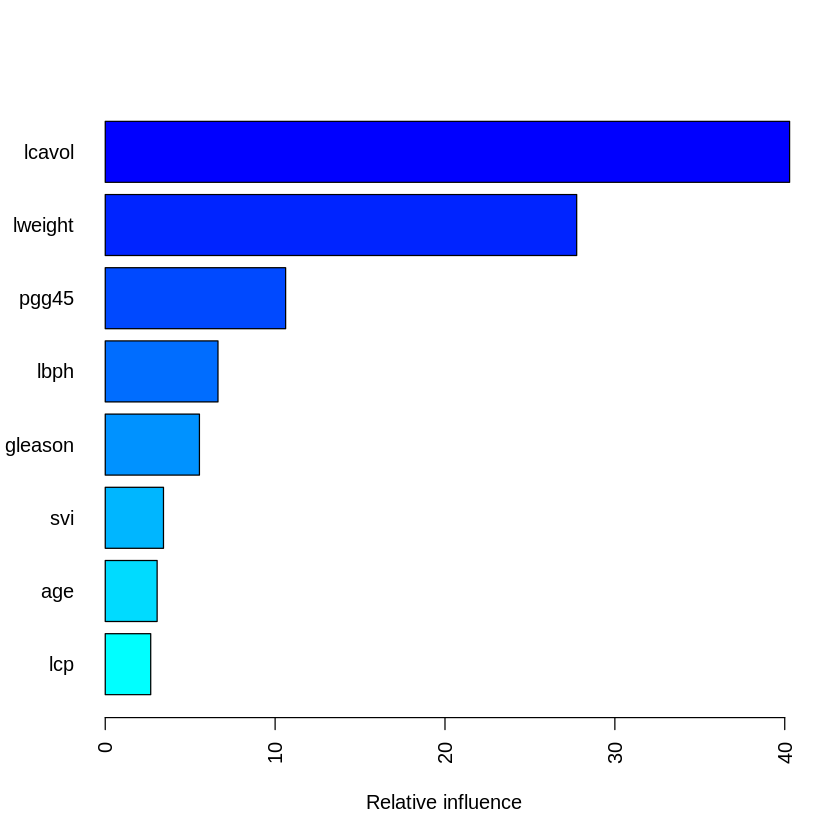

In [68]:
# relative influence approach
summary(train_boostreg$finalModel,
  method = relative.influence,
  normalize = TRUE, las = 2)

var,rel.inf
<chr>,<dbl>
lcavol,50.3500197
lweight,32.4414165
pgg45,9.1148859
lbph,2.9733741
gleason,2.7814915
svi,1.1306584
lcp,0.9137586
age,0.2943953


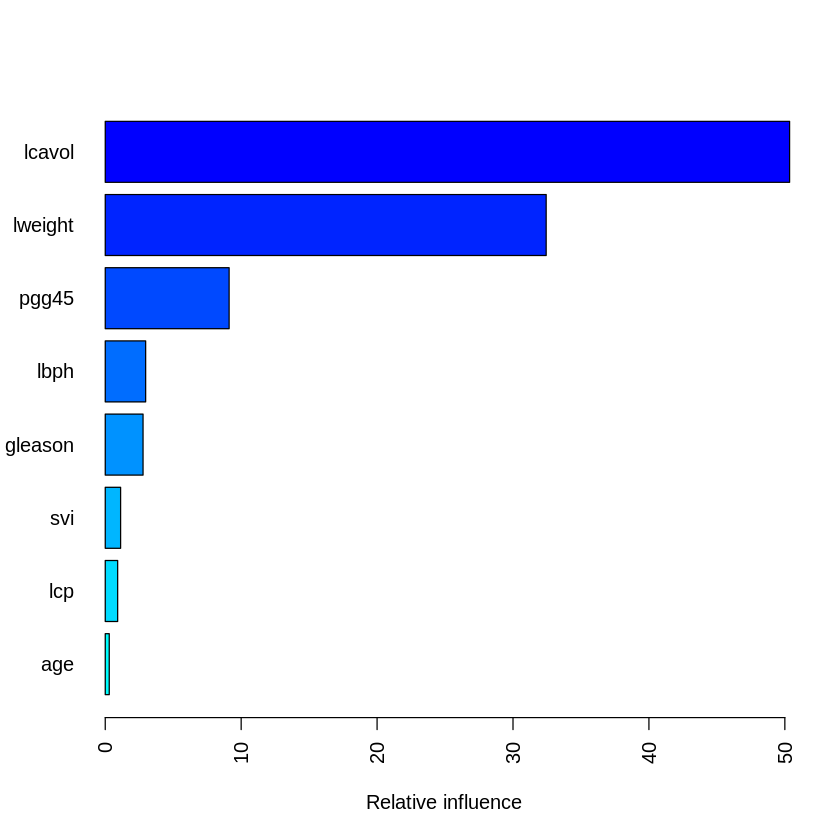

In [69]:
# permutation approach
summary(train_boostreg$finalModel,
  method = permutation.test.gbm,
  normalize = TRUE, las = 2)

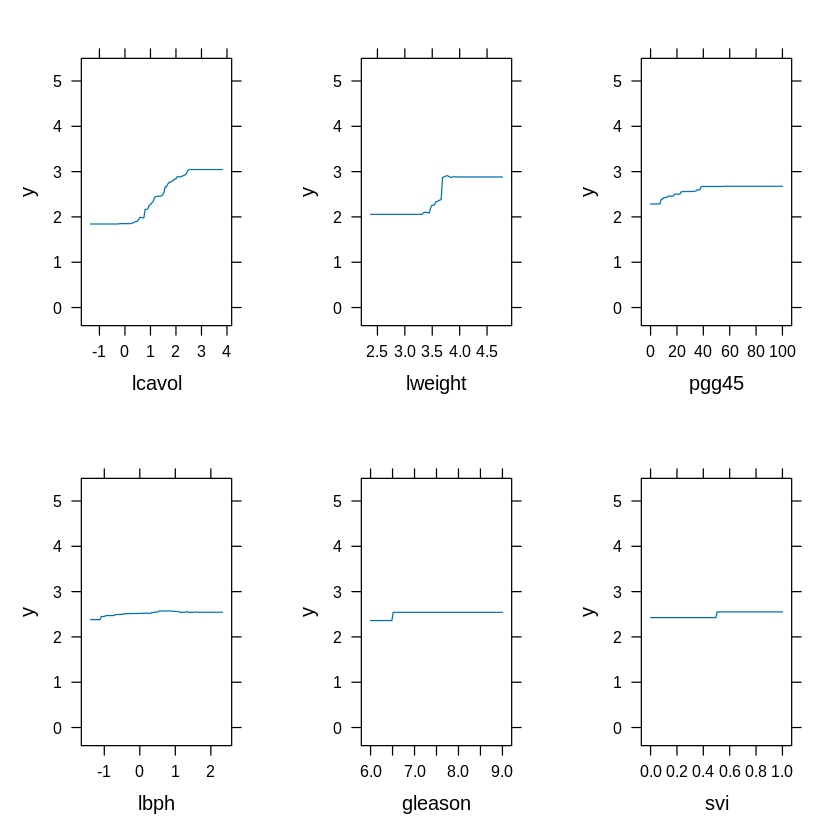

In [70]:
p1 <- plot(train_boostreg$finalModel, i = "lcavol", ylim = c(-0.40, 5.5))
p2 <- plot(train_boostreg$finalModel, i = "lweight", ylim = c(-0.40, 5.5))
p3 <- plot(train_boostreg$finalModel, i = "pgg45", ylim = c(-0.40, 5.5))
p4 <- plot(train_boostreg$finalModel, i = "lbph", ylim = c(-0.40, 5.5))
p5 <- plot(train_boostreg$finalModel, i = "gleason", ylim = c(-0.40, 5.5))
p6 <- plot(train_boostreg$finalModel, i = "svi", ylim = c(-0.40, 5.5))

grid.arrange(p1, p2, p3, p4, p5, p6, ncol = 3, nrow = 2)

# Boosted Classification Tree

In [ ]:
heart_data <- read_csv("/content/Heart.csv")

# convert ChestPain and Thal to factor variables
heart_data$ChestPain <- factor(heart_data$ChestPain)
heart_data$Thal <- factor(heart_data$Thal)

# split into training and test sets
set.seed(1234)

heart_train_row <- sort(sample(1:303, size = 202))
heart_test_row <- setdiff(1:303, heart_train_row)
heart_data_train <- heart_data[heart_train_row,]
heart_data_test <- heart_data[heart_test_row,]

# remove subjects with missing data
heart_data_train <- heart_data_train[complete.cases(heart_data_train),]
heart_data_test <- heart_data_test[complete.cases(heart_data_test),]

# create predictor matrix and response vector
heart_data_train_X <- heart_data_train[,1:13]
heart_data_train_Y <- factor(heart_data_train$AHD)

# set up tuning grid
tg_boostclass <- expand.grid(n.trees = c(200, 400, 600, 800),
  interaction.depth = 1:5,
  shrinkage = c(0.0001, 0.001, 0.01, 0.1),
  n.minobsinnode = 10)

In [ ]:
set.seed(1234)
train_boostclass <- train(x = heart_data_train_X, y = heart_data_train_Y,
  method = "gbm", bag.fraction = 0.50, tuneGrid = tg_boostclass,
  trControl = trainControl(method = "cv", number = 10))

In [81]:
train_boostclass$bestTune

,n.trees,interaction.depth,shrinkage,n.minobsinnode
,<dbl>,<int>,<dbl>,<dbl>
58,400,5,0.01,10


In [82]:
train_boostclass$results[which.max(train_boostclass$results$Accuracy),]

,shrinkage,interaction.depth,n.minobsinnode,n.trees,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
58,0.01,5,10,400,0.7380075,0.4686431,0.08609241,0.1815868


,var,rel.inf
,<chr>,<dbl>
Thal,Thal,18.3750815
Ca,Ca,17.1290144
ChestPain,ChestPain,15.0065651
Oldpeak,Oldpeak,10.9874694
MaxHR,MaxHR,8.5422366
Age,Age,8.4392178
Chol,Chol,5.8411460
Slope,Slope,4.3682857
RestBP,RestBP,4.1315563


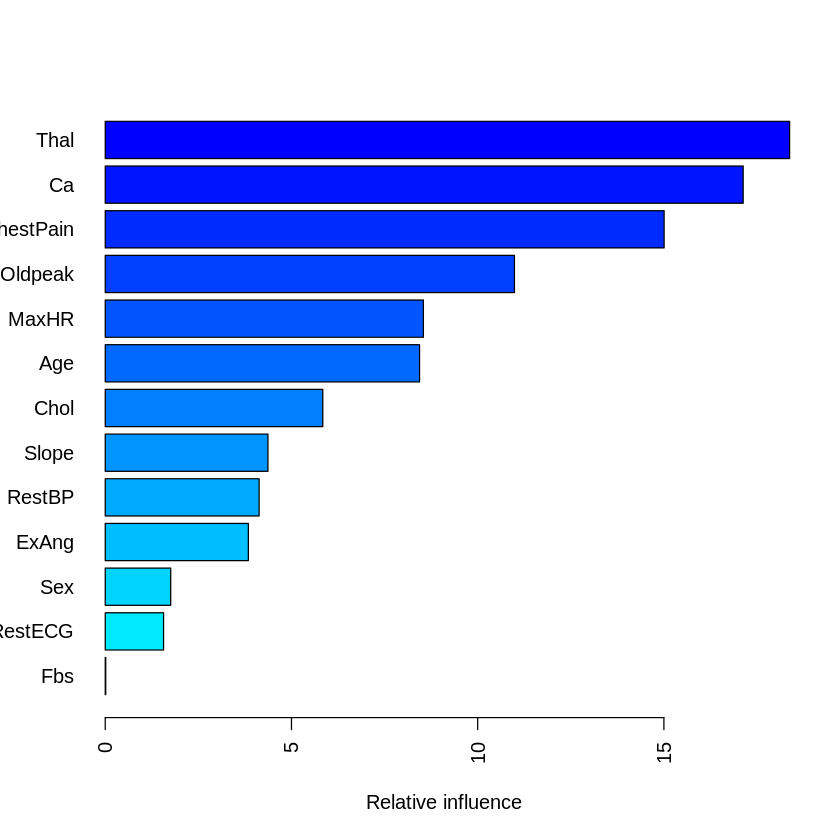

In [83]:
# relative influence approach
summary(train_boostclass$finalModel,
  method = relative.influence,
  normalize = TRUE, las = 2)

var,rel.inf
<chr>,<dbl>
Ca,21.171515442
Thal,19.348077838
ChestPain,17.187107091
Oldpeak,11.652349209
Age,7.354363935
Slope,5.179278509
MaxHR,4.816854430
Chol,3.834032379
ExAng,3.679603047


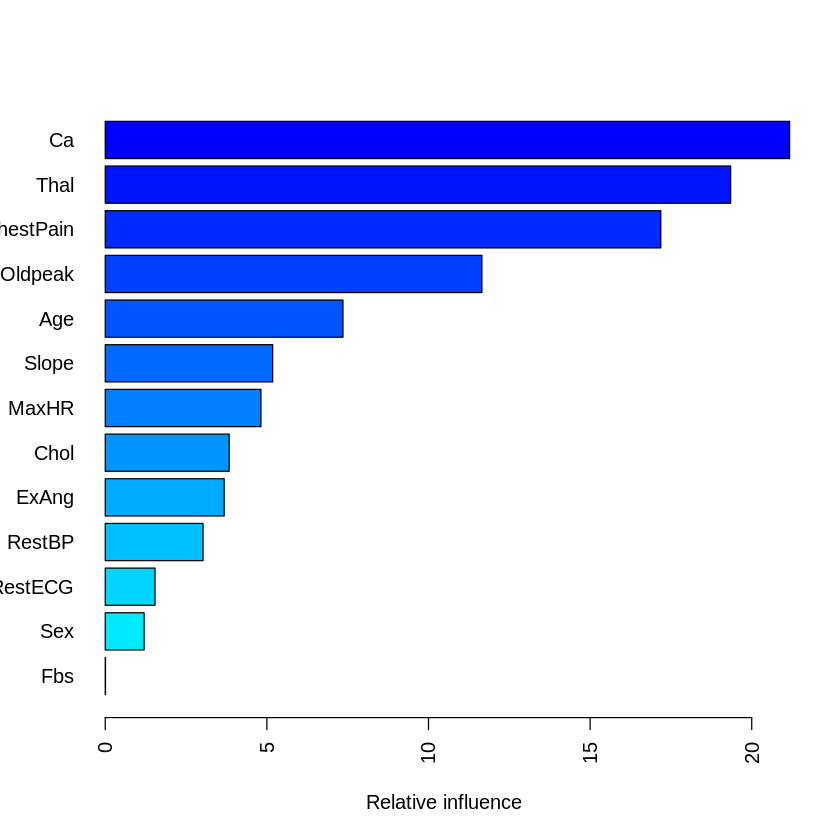

In [84]:
# permutation approach
summary(train_boostclass$finalModel,
  method = permutation.test.gbm,
  normalize = TRUE, las = 2)

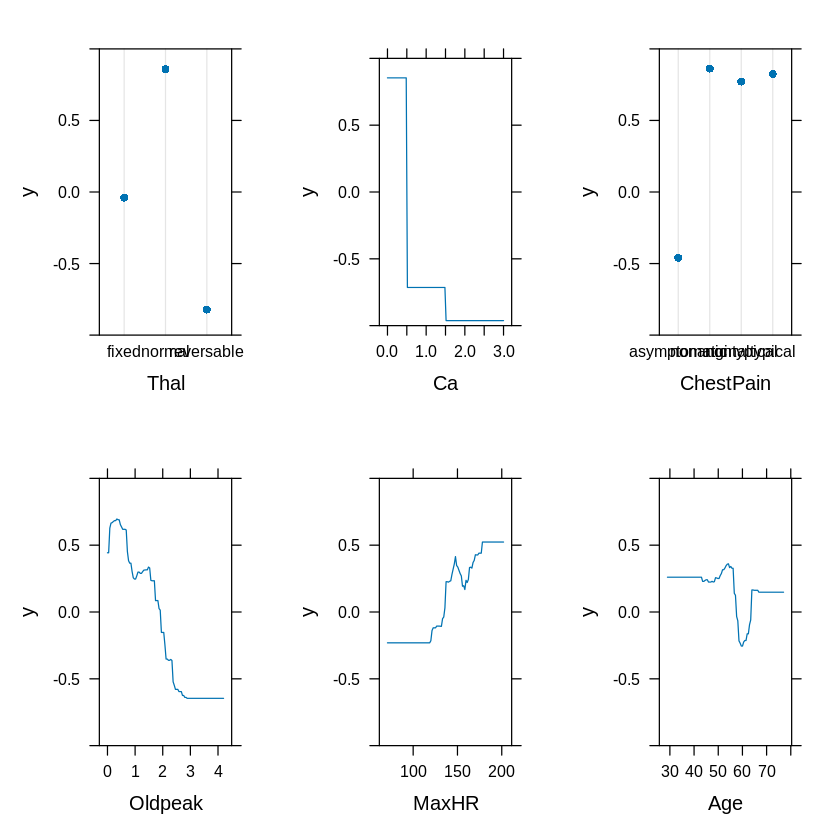

In [85]:
p1 <- plot(train_boostclass$finalModel, i = "Thal", ylim = c(-1, 1))
p2 <- plot(train_boostclass$finalModel, i = "Ca", ylim = c(-1, 1))
p3 <- plot(train_boostclass$finalModel, i = "ChestPain", ylim = c(-1, 1))
p4 <- plot(train_boostclass$finalModel, i = "Oldpeak", ylim = c(-1, 1))
p5 <- plot(train_boostclass$finalModel, i = "MaxHR", ylim = c(-1, 1))
p6 <- plot(train_boostclass$finalModel, i = "Age", ylim = c(-1, 1))

grid.arrange(p1, p2, p3, p4, p5, p6, ncol = 3, nrow = 2)